# Recommendation/Resolution "Actionable?" Analysis Using Implementation Status

#### Background
Each recommendation deemed to directly impact gentrification in the dataset is determined to be "Actionable" or "Not Actionable". They also have varying implementation status. The implementation status data is messy but mostly contains variations of implemented, presumed implemented, underway, unknown, or N/A. 

#### Question
Do each recommendation's actionability determination align with it's implementation status? If a recommendation is implemented, presumed implemented, or underway, it makes sense that it would be considered actionable.

#### Approach
- Create an OpenAI assistant that can analyze the dataset
- Clean and categorize the implementation data in a new column using the Assistant. Have the assistant justify its decisions for further analysis.
- Create a "New Actionable?" column referencing implementation categories using Pandas
- Compare the "New Actionable?" and original "Actionable?" data

## Create OpenAI Assistant and Upload Dataset

In [1]:
%reload_ext autoreload
%autoreload 2

import sys
import os
file_dir = os.path.abspath('')
sys.path.append(file_dir)

from openai import OpenAI
import assistant_helper
import pandas as pd

ai_instructions = "You are a data analyst and statistician. You are cleaning and improving the attached CSV dataset."
assistant = assistant_helper.create_openai_assistant('Displacement_and_Gentrification_Recommendation_Inventory.csv', 'AI Analyst', ai_instructions)

client = OpenAI()


## Analyze "Actionable?" Values Using Implementation Status

### Categorize Implementation Status Data
- The current "Status of the Recommendation/Resolution Data" needs to be cleaned.
- Instruct the Assistant to categorize each recommendation's implementation status so we can use the data in further analysis.
- The Assistant will justify its categorization in another column.

In [2]:
# Create a new thread
thread = client.beta.threads.create()

# Add message to thread
message = client.beta.threads.messages.create(
    thread_id=thread.id,
    role="user",
    content="""
"As a data analyst and statistician, your task is to refine the provided dataset. Focus on the creation and completion of a new column named 'Implementation Category'. No output cell should be left blank. Adhere to the following step-by-step guidelines for each entry in the dataset:

1. Examine: Review each entry under the column 'Status of the Recommendation/Resolution'. Pay close attention to its content.

2. Categorize: Based on your examination, assign one of the following categories to the content:
   - Implemented
   - Presumed Implemented
   - Underway
   - Unknown
   - Not implemented
   - N/A (Use this if the 'Status of the Recommendation/Resolution' field is empty). Do not leave empty cells!

3. Populate: In the 'Implementation Status' column, record the category you determined in step 2. Ensure no cell is left blank. If unsure, default to "N/A".

4. Justify: In a subsequent column titled 'Implementation Category Reasoning', document your reasoning for the category choice made in step 3.

Upon completion, provide the updated dataset in a CSV format, ensuring it includes these new columns for integration into a pandas dataframe."

No cells should be blank in the new rows. Replace blank cells with "N/A"

"""
)

# Start a run on the thread
messages = assistant_helper.start_run_on_thread(client, thread.id, assistant.id)
print(messages.data[0].content[0].text.value)



Completed!          
The updated dataset has been saved as a CSV file. You can download the updated dataset using the following link:

[Download the updated dataset](sandbox:/mnt/data/updated_dataset.csv)


### Process CSV Output

In [3]:
import io

# Access returned CSV
first_message = messages.data[0]
if first_message.file_ids:
    file_id = first_message.file_ids[0]
    print(f"File identified: {file_id}")

else:
    print("No file identified in first message.")

# Read binary stream
file_content = client.files.content(file_id)
file_bytes = file_content.read()
file_bytes_io = io.BytesIO(file_bytes)

# Read as CSV
implementation_category_df = pd.read_csv(file_bytes_io)

# # Save CSV to out folder
# file_name = os.path.join("out", "Implementation_Category.csv") 
# implementation_category_df.to_csv(file_name, encoding='utf-8', index=False)
# print(f"Output CSV saved in {file_name}")

display(implementation_category_df)

File identified: file-972y1z9X0f4rDyvd3X6Nu3QV
Output CSV saved in out/Implementation_Category.csv


,Year (CY),Type,Source,Summary,Recommendation/Resolution,Implementing Department,Action Category,Direct/Indirect?,Targeted at Homelessness?,Actionable?,Status of the Recommendation/Resolution,Implementation Category,Implementation Category Reasoning
0,2011,OCA Audit,Affordable Housing: Rental Housing and Acquisi...,NaN,In order to support the efficiency and effecti...,NHCD,Monitoring,Indirect,No,NaN,NaN,NaN,The Status field is empty.
1,2011,OCA Audit,Affordable Housing: Rental Housing and Acquisi...,NaN,The NHCD Director should improve existing proc...,NHCD,Recommendations for process improvements,Indirect,No,NaN,NaN,NaN,The Status field is empty.
2,2012,OCA Audit,Austin Energy Customer Assistance Programs Audit,NaN,AE management should work with Council to iden...,Austin Energy,Financing,Indirect,No,NaN,NaN,NaN,The Status field is empty.
3,2012,OCA Audit,Austin Energy Customer Assistance Programs Audit,NaN,AE management should work with the Plus 1 Prog...,Austin Energy,Financing,Indirect,No,NaN,NaN,NaN,The Status field is empty.
4,2015,OCA Audit,Austin Energy Low-Income Weatherization Progra...,NaN,5. Austin Energy management should continue to...,Austin Energy,Financing,Indirect,No,NaN,NaN,NaN,The Status field is empty.
...,...,...,...,...,...,...,...,...,...,...,...,...,...
536,2013,Council Resolution,20130808-052,Resolution initiating amendments to the City C...,• City Council initiates amendments to City Co...,City Manager,Preserving and expanding the supply of afforda...,Direct,No,Actionable,Implemented,Implemented,Categorized as Implemented based on the conten...
537,2002,Task Force,Gentrification Implications of Historic Zoning...,NaN,6. Educate residents about their legal rights ...,Council,Recommendations for planning and approach,Direct,No,Actionable,Status unknown: commission and taskforce recom...,Unknown,"Categorized as Unknown based on the content: ""..."
538,2004,Council Resolution,20041202-59,A resolution adopting the City's Affordable Ho...,The following strategies for reporting Catellu...,City Manager,Controlling land for community development,Direct,No,Actionable,"Status unknown: according to CMO, item predate...",Unknown,"Categorized as Unknown based on the content: ""..."
539,2016,Council Resolution,20160303-018,Directing the City Manager to initiate amendme...,• City Manager directed to initiate amendments...,City Manager,Financing,Direct,No,Actionable,Implemented,Implemented,Categorized as Implemented based on the conten...


### Create "New Actionable?" Column using Implementation Status
- The current "Actionable?" column contains many empty cells.
- If a recommendation is presumed implemented, underway, or implemented we can assume that it is actionable.
- Create a new column "New Actionable?" using this logic.

In [4]:
new_actionable_df = implementation_category_df

def update_new_actionable(row):
    if row["Implementation Category"] in ["Implemented", "Presumed Implemented", "Underway"]:
        return "Actionable"
    elif row["Implementation Category"] == "N/A" and (pd.isnull(row["Actionable?"]) or row["Actionable?"].strip() in ["Unknown", "", "N/A"]):
        return "Unknown"
    else:
        return row["Actionable?"]

new_actionable_df["New Actionable?"] = new_actionable_df.apply(update_new_actionable, axis=1)

display(new_actionable_df)

# Save CSV to out folder
file_name = os.path.join("out", "New_Actionable.csv") 
implementation_category_df.to_csv(file_name, encoding='utf-8', index=False)
print(f"Output CSV saved in {file_name}")


,Year (CY),Type,Source,Summary,Recommendation/Resolution,Implementing Department,Action Category,Direct/Indirect?,Targeted at Homelessness?,Actionable?,Status of the Recommendation/Resolution,Implementation Category,Implementation Category Reasoning,New Actionable?
0,2011,OCA Audit,Affordable Housing: Rental Housing and Acquisi...,NaN,In order to support the efficiency and effecti...,NHCD,Monitoring,Indirect,No,NaN,NaN,NaN,The Status field is empty.,NaN
1,2011,OCA Audit,Affordable Housing: Rental Housing and Acquisi...,NaN,The NHCD Director should improve existing proc...,NHCD,Recommendations for process improvements,Indirect,No,NaN,NaN,NaN,The Status field is empty.,NaN
2,2012,OCA Audit,Austin Energy Customer Assistance Programs Audit,NaN,AE management should work with Council to iden...,Austin Energy,Financing,Indirect,No,NaN,NaN,NaN,The Status field is empty.,NaN
3,2012,OCA Audit,Austin Energy Customer Assistance Programs Audit,NaN,AE management should work with the Plus 1 Prog...,Austin Energy,Financing,Indirect,No,NaN,NaN,NaN,The Status field is empty.,NaN
4,2015,OCA Audit,Austin Energy Low-Income Weatherization Progra...,NaN,5. Austin Energy management should continue to...,Austin Energy,Financing,Indirect,No,NaN,NaN,NaN,The Status field is empty.,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
536,2013,Council Resolution,20130808-052,Resolution initiating amendments to the City C...,• City Council initiates amendments to City Co...,City Manager,Preserving and expanding the supply of afforda...,Direct,No,Actionable,Implemented,Implemented,Categorized as Implemented based on the conten...,Actionable
537,2002,Task Force,Gentrification Implications of Historic Zoning...,NaN,6. Educate residents about their legal rights ...,Council,Recommendations for planning and approach,Direct,No,Actionable,Status unknown: commission and taskforce recom...,Unknown,"Categorized as Unknown based on the content: ""...",Actionable
538,2004,Council Resolution,20041202-59,A resolution adopting the City's Affordable Ho...,The following strategies for reporting Catellu...,City Manager,Controlling land for community development,Direct,No,Actionable,"Status unknown: according to CMO, item predate...",Unknown,"Categorized as Unknown based on the content: ""...",Actionable
539,2016,Council Resolution,20160303-018,Directing the City Manager to initiate amendme...,• City Manager directed to initiate amendments...,City Manager,Financing,Direct,No,Actionable,Implemented,Implemented,Categorized as Implemented based on the conten...,Actionable


Output CSV saved in out/New_Actionable.csv


### Visualize "Actionable?" Data Compared to "New Actionable?"

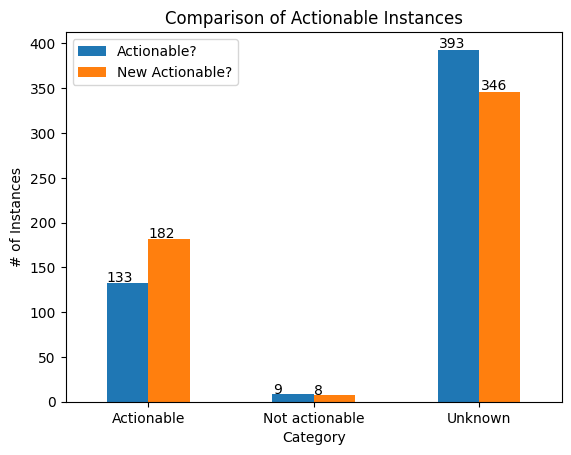

In [5]:
import matplotlib.pyplot as plt

df = new_actionable_df

# Replace empty cells with 'Unknown'
df['Actionable?'] = df['Actionable?'].fillna('Unknown')
df['New Actionable?'] = df['New Actionable?'].fillna('Unknown')

# Count the instances of each category in both columns
actionable_counts = df['Actionable?'].value_counts()
new_actionable_counts = df['New Actionable?'].value_counts()

# Prepare the data for plotting
plot_data = pd.DataFrame({
    'Actionable?': actionable_counts,
    'New Actionable?': new_actionable_counts
})

# Ensure all categories are present in both columns
plot_data = plot_data.reindex(['Actionable', 'Not actionable', 'Unknown']).fillna(0)

# Plotting
ax = plot_data.plot(kind='bar')
plt.xlabel('Category')
plt.ylabel('# of Instances')
plt.title('Comparison of Actionable Instances')
plt.xticks(rotation=0)  # Rotates the x-axis labels to horizontal

# Adding labels to the bars
for p in ax.patches:
    ax.annotate(str(int(p.get_height())), (p.get_x() * 1.005, p.get_height() * 1.005))

plt.show()
